In [45]:
import numpy as np
import pandas as pd
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import multiprocessing as mp
import pickle
from tqdm import tqdm

from sandpileDynamics import *

## Tau analysis

In [2]:
## Helper functions
def estimate_gamma(g):
    degrees = [d for n, d in g.degree()]
    fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
    return np.float32(fit.power_law.alpha)

def fit_tau(area, occurrences, cutoff):
    x = np.log10(area)[:cutoff]
    y = np.log10(occurrences)[:cutoff]
    # Linear fit
    fit = np.polyfit(x, y, 1)
    tau = -fit[0]
    return tau

def tau_from_data(data, cutoff):
    area = data.groupby("A", as_index=False).count()
    tau = fit_tau(area["A"], area['iteration'], cutoff)
    return tau

In [3]:
# Load the data
N = 10_000
f = 1/N
iterations = 1e6

labels = [
    "BA_5", 
    "BA_1", 
    "ER_0-0007", 
    "ER_0-002", 
    "SF_0-1_0-1_0-8", 
    "SF_0-35_0-3_0-35", 
    "SF_0-4_0-1_0-5", 
    "SF_0-2_0-7_0-1"
]

labels2 = [
    r"BA $m=5$",
    r"BA $m=1$",
    r"ER $p=0.0007$",
    r"ER $p=0.002$",
    r"SF $\alpha=0.1$, $\beta=0.1$, $\gamma=0.8$",
    r"SF $\alpha=0.35$, $\beta=0.3$, $\gamma=0.35$",
    r"SF $\alpha=0.4$, $\beta=0.1$, $\gamma=0.5$",
    r"SF $\alpha=0.2$, $\beta=0.7$, $\gamma=0.1$"
]

networks = []
for label in labels:
  with open(f"temp_data/{label}.gpickle", "rb") as f:
      networks.append(pickle.load(f))

data = []
for label in labels:
    with open(f"temp_data/{label}.csv", "rb") as f:
        data.append(pd.read_csv(f))

In [4]:
data[0].tail()

,Unnamed: 0,iteration,S,T,G,A
1300737,1300737,9999948,1,1,5,1
1300738,1300738,9999959,1,1,7,1
1300739,1300739,9999967,6,5,77,6
1300740,1300740,9999973,1,1,6,1
1300741,1300741,9999982,1,1,5,1


In [ ]:
## Quantities of interest
estimated_gamma = [estimate_gamma(g) for g in networks]
estimated_tau = [tau_from_data(d, 10) for d in data]

theoretical_tau = []
for gamma in estimated_gamma:
    if gamma < 3:
       theoretical_tau.append(gamma/(gamma - 1))
    else:
        theoretical_tau.append(1.5)

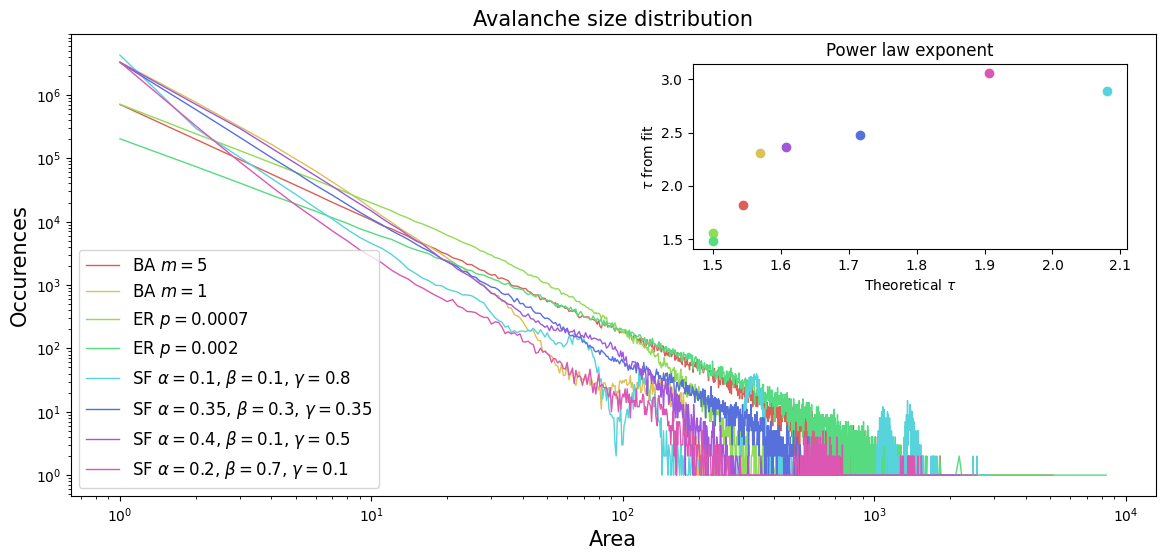

In [22]:
colors = sns.color_palette("hls", n_colors=len(labels))
fig, ax = plt.subplots(figsize=(14, 6))
for i in range(len(labels)):
    res = data[i]
    area = res.groupby("A", as_index=False).count()
    
    ax.plot(area["A"], area["iteration"], label=labels2[i], lw=1, color=colors[i])

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Area", fontsize=15)
ax.set_ylabel("Occurences", fontsize=15)
ax.set_title("Avalanche size distribution", fontsize=15)
ax.legend(loc="lower left", fontsize=12)

inset_ax = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.58, 0.55, 0.4, 0.4), bbox_transform=ax.transAxes)
for i in range(len(labels)):
    inset_ax.scatter(theoretical_tau[i], estimated_tau[i], color=colors[i])
#inset_ax.plot([1.5, 2], [1.5, 2], color="black", linestyle="--")
inset_ax.set_xlabel(r"Theoretical $\tau$")
inset_ax.set_ylabel(r"$\tau$ from fit")
inset_ax.set_title("Power law exponent");

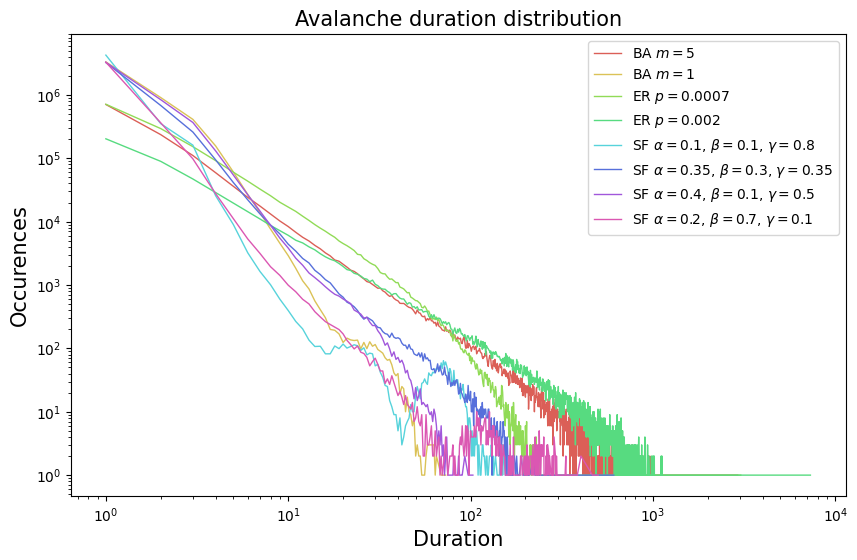

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(labels)):
    res = data[i]
    area = res.groupby("T", as_index=False).count()
    
    ax.plot(area["T"], area["iteration"], label=labels2[i], lw=1, color=colors[i])
    #ax.scatter(area["T"], area["iteration"], color=colors[i], s=3)

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(1, 100)

ax.set_xlabel("Duration", fontsize=15)
ax.set_ylabel("Occurences", fontsize=15)
ax.set_title("Avalanche duration distribution", fontsize=15)
ax.legend(loc="upper right");

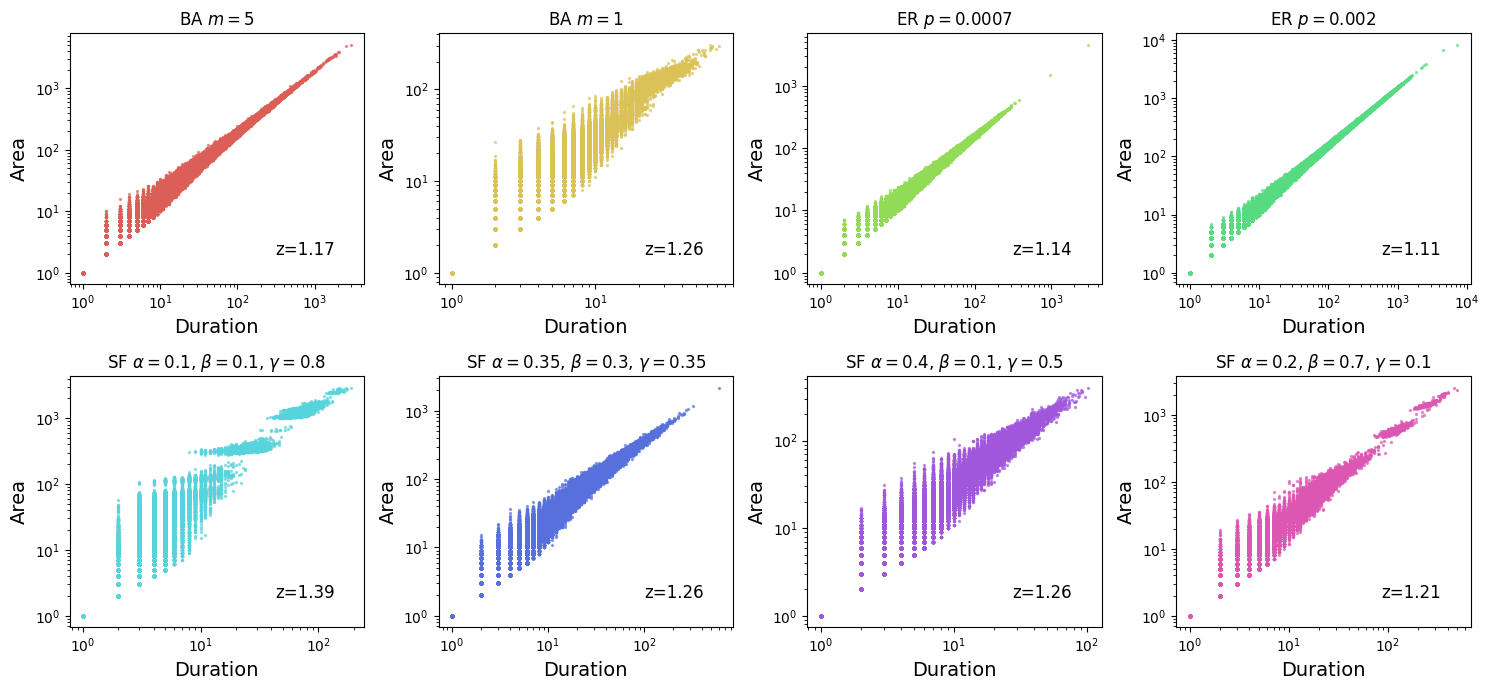

In [28]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
for i in range(len(labels)):
    res = data[i]
    
    ax[i//4, i%4].scatter(res["T"], res["A"], label=labels2[i], color=colors[i], s=2, alpha=0.6)

    ax[i//4, i%4].set_xscale("log")
    ax[i//4, i%4].set_yscale("log")
    
    ax[i//4, i%4].set_title(labels2[i])
    ax[i//4, i%4].set_xlabel("Duration", fontsize=14)
    ax[i//4, i%4].set_ylabel("Area", fontsize=14)

    z = np.polyfit(np.log10(res["T"]), np.log10(res["A"]), 1)[0]
    ax[i//4, i%4].text(0.9, 0.1, f"z={z:.2f}", ha='right', va='bottom', transform=ax[i//4, i%4].transAxes, fontsize=12)
    #ax[i//4, i%4].plot(res["T"], 10**z * res["T"], color="black", linestyle="--", lw=1)

plt.tight_layout();

## Example of Coupled graph

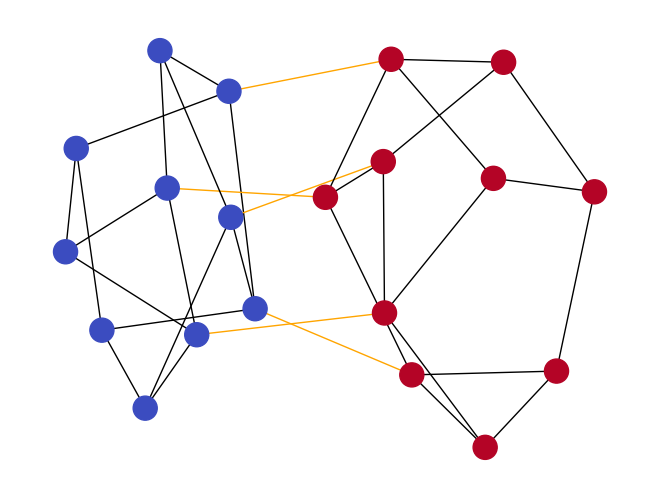

In [44]:
g_coupled, belongs_to = getCoupledGraph(10, 0.5)
# Create edge colors based on whether the edge connects nodes from the same or different subgraphs
edge_colors = []
for u, v in g_coupled.edges():
    if belongs_to[u] == belongs_to[v]:
        edge_colors.append('black')  # Same subgraph
    else:
        edge_colors.append('orange')   # Different subgraphs

# Draw the graph
pos = nx.spring_layout(g_coupled)  # Layout for consistent plotting
nx.draw(g_coupled, pos, node_color=belongs_to, with_labels=False, cmap='coolwarm', edge_color=edge_colors)